In [4]:
NEED_TO_INSTALL_PACKAGES = True
if NEED_TO_INSTALL_PACKAGES:
    !pip install tensorboard psutil gwpy lalsuite bilby>=2.1.2
    !pip install swyft
    !pip install torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.5/829.5 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.9/206.9 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 20.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 44.8 MB/s eta 0:00:00
  Created wheel for asciitree: filename=asciitree-0.3.3-py3-none-any.whl size=5033 sha256=62051eee24b818dd8f0842d7c4e2ea0e07b81549e169e594b1066cfbbeccce55
  Stored in directory: /root/.cache/pip/wheels/7f/4e/be/1171b40f43b918087657ec57cf3b81fa1a2e027d8755baa184
Successfully built asciitree


## SIMULATION-BASED EXAMPLE

In [5]:
import swyft.lightning as sl
import torch
import numpy as np
import matplotlib.pyplot as plt
import bilby

In [6]:
injection_parameters = dict(m=0.5, c=0.2)


time_duration = 10
sampling_frequency = 10
time = np.arange(0, time_duration, 1 / sampling_frequency)
N = len(time)
sigma = np.random.normal(1, 0.01, N)

model_parameters = dict(
        sampling_frequency = sampling_frequency,
        time_duration = time_duration,
        time = time,
        N = N,
        sigma = sigma,)

priors = dict()
priors["m"] = bilby.core.prior.Uniform(0, 10, "m")
priors["c"] = bilby.core.prior.Uniform(-5, 5, "c")

In [7]:
class Simulator(sl.Simulator):
    def __init__(self, model_parameters):
        super().__init__()
        self.model_parameters = model_parameters
        self.priors = priors

    def sample_priors(self):
        params = np.array([self.priors[p].sample() for p in self.priors])
        return params

    def model(self,params):
        param_dict = dict(zip(self.priors.keys(), params))
        signal = self.model_parameters['time'] * param_dict['m'] + param_dict['c']
        return signal

    def noise(self):
        noise = np.random.normal(0, self.model_parameters['sigma'], self.model_parameters['N'])
        return noise

    def build(self,graph):
        params = graph.node('params', self.sample_priors)
        signal = graph.node('signal', self.model, params)
        noise = graph.node('noise', self.noise)

In [8]:
sim = Simulator(model_parameters)

In [9]:
shapes, dtypes = sim.get_shapes_and_dtypes()
store = sl.ZarrStore("store_regression")
store.init(
    N = 5_000,
    chunk_size=1000,
    shapes=shapes,
    dtypes=dtypes,
)

In [10]:
store.sims_required

5000

In [11]:
store.simulate(sim, batch_size=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [12]:
print(store.keys())
print(store['signal'].shape)
print(store['params'].shape)

['noise', 'params', 'signal']
(5000, 100)
(5000, 2)


In [44]:
class Network(sl.SwyftModule):
    def __init__(self):
        super().__init__()
        self.embedding_network = torch.nn.LazyLinear(32)
        self.activation = torch.nn.ReLU()
        self.logratios_1d = sl.LogRatioEstimator_1dim(num_features=32, num_params=2, varnames='params', hidden_features=16)
        self.logratios_2d = sl.LogRatioEstimator_Ndim(num_features=32, marginals=((0, 1),), varnames='params', hidden_features=16)
        self.optimizer_init = sl. AdamW()
        self.batch_size = 64

    def forward(self, A, B):
        signal = A['signal']
        noise_shuffling = torch.randperm(signal.shape[0])
        data = A['signal'] + A['noise'][noise_shuffling]
        params = B['params']
        data = self.embedding_network(data)
        data = self.activation(data)
        logratios_1d = self.logratios_1d(data, params)
        logratios_2d = self.logratios_2d(data, params)
        return logratios_1d, logratios_2d

In [45]:
network = Network()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [46]:
train_data = store.get_dataloader(
    num_workers=2,
    batch_size=64,
    idx_range=[0, 4500],
)

val_data = store.get_dataloader(
    num_workers=2,
    batch_size=64,
    idx_range=[4500, 5000],
)

In [47]:
trainer = sl.SwyftTrainer(accelerator = 'cpu', precision=64, min_epochs=5, max_epochs=50)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [48]:
### TRAIN THE NETWORK
trainer.fit(network, train_data, val_data)

INFO:pytorch_lightning.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
INFO:pytorch_lightning.callbacks.model_summary:
  | Name              | Type                   | Params
-------------------------------------------------------------
0 | embedding_network | LazyLinear             | 0     
1 | activation        | ReLU                   | 0     
2 | logratios_1d      | LogRatioEstimator_1dim | 3.6 K 
3 | logratios_2d      | LogRatioEstimator_Ndim | 1.8 K 
-------------------------------------------------------------
5.3 K     Trainable params
0         Non-trainable params
5.3 K     Total params
0.043     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Reloading best model: /content/lightning_logs/version_4/checkpoints/epoch=5-step=462.ckpt


In [49]:
prior_samples = sim.sample(100_000, targets=['params'])

  0%|          | 0/100000 [00:00<?, ?it/s]

In [50]:
obs_signal = sim.model([injection_parameters['m'], injection_parameters['c']])
obs_noise = sim.noise()

obs = sl.Sample(
    {'params' : np.array([injection_parameters['m'], injection_parameters['c']]),
     'noise' : obs_noise,
     'signal' : obs_signal,
     }
)

In [51]:
logratios = trainer.infer(network, obs, prior_samples.get_dataloader(batch_size=2048))

INFO:pytorch_lightning.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting: 77it [00:00, ?it/s]

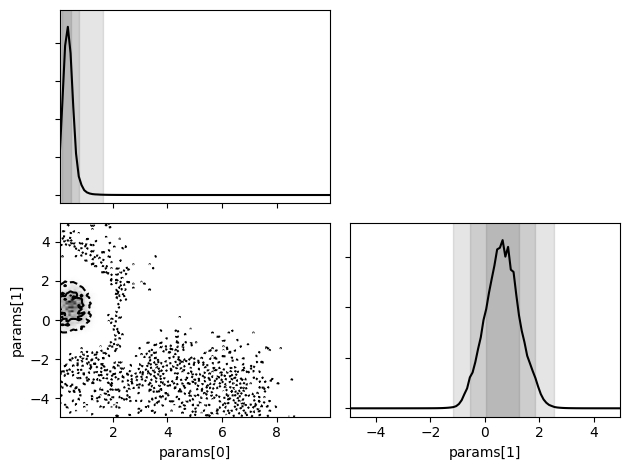

In [64]:
sl.swyft.plot_corner(logratios, parnames=["params[0]", "params[1]"]);

## LIKELIHOOD-BASED EXAMPLE

In [ ]:
time = np.arange(0, time_duration, 1 / sampling_frequency)
sigma = np.random.normal(1, 0.01, N)

model_parameters = dict(
        sampling_frequency = 10,
        time_duration = 10,
        time = time,
        N = len(time),
        sigma = sigma,)

priors = dict()
priors["m"] = bilby.core.prior.Uniform(0, 10, "m")
priors["c"] = bilby.core.prior.Uniform(-5, 5, "c")

In [ ]:
# A few simple setup steps
label = "linear_regression"
outdir = "outdir_bilby"
bilby.utils.check_directory_exists_and_if_not_mkdir(outdir)

In [20]:
# First, we define our "signal model", in this case a simple linear function
def model(time, m, c):
    return time * m + c

def noise(sigma, N):
    noise = np.random.normal(0, sigma, N)
    return noise

In [ ]:
# Now we define the injection parameters which we make simulated data with
injection_parameters = dict(m=0.5, c=0.2)

sampling_frequency = 10
time_duration = 10
time = np.arange(0, time_duration, 1 / sampling_frequency)
N = len(time)
sigma = np.random.normal(1, 0.01, N)

In [24]:
signal = model(model_parameters['time'], **injection_parameters)
noise = noise(model_parameters['sigma'], model_parameters['N'])
data = signal + noise

Text(0, 0.5, 'Signal amplitude')

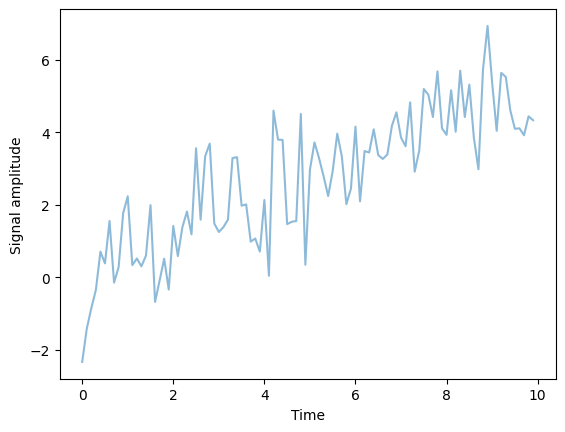

In [ ]:
# plt.plot(time, signal)
plt.plot(model_parameters['time'], data, alpha=0.5)

plt.xlabel("Time")
plt.ylabel("Signal amplitude")

In [ ]:
# From hereon, the syntax is exactly equivalent to other bilby examples
# We make a prior
priors = dict()
priors["m"] = bilby.core.prior.Uniform(0, 10, "m")
priors["c"] = bilby.core.prior.Uniform(-5, 5, "c")

In [ ]:
# Now lets instantiate a version of our GaussianLikelihood, giving it
# the time, data and signal model
likelihood = bilby.likelihood.GaussianLikelihood(model_parameters['time'], data, model, sigma)

22:22 bilby INFO    : Running for label 'linear_regression', output will be saved to 'outdir_bilby'
22:22 bilby INFO    : Analysis priors:
22:22 bilby INFO    : m=Uniform(minimum=0, maximum=10, name='m', latex_label='m', unit=None, boundary=None)
22:22 bilby INFO    : c=Uniform(minimum=-5, maximum=5, name='c', latex_label='c', unit=None, boundary=None)
22:22 bilby INFO    : Analysis likelihood class: <class 'bilby.core.likelihood.GaussianLikelihood'>
22:22 bilby INFO    : Analysis likelihood noise evidence: nan
22:22 bilby INFO    : Single likelihood evaluation took 1.090e-04 s
22:22 bilby INFO    : Using sampler Dynesty with kwargs {'nlive': 250, 'bound': 'multi', 'sample': 'rwalk', 'periodic': None, 'reflective': None, 'update_interval': None, 'first_update': None, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'gradient': None, 'grad_args': None, 

1it [00:00, ?it/s]

22:24 bilby INFO    : Written checkpoint file outdir_bilby/linear_regression_resume.pickle


22:25 bilby INFO    : Sampling time: 0:02:16.092844
22:25 bilby INFO    : Summary of results:
nsamples: 2935
ln_noise_evidence:    nan
ln_evidence: -152.979 +/-  0.209
ln_bayes_factor:    nan +/-  0.209



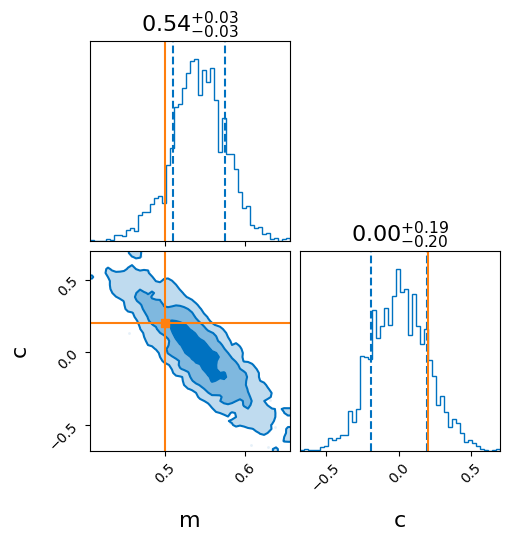

In [ ]:
# And run sampler
result = bilby.run_sampler(
    likelihood=likelihood,
    priors=priors,
    sampler="dynesty",
    nlive=250,
    injection_parameters=injection_parameters,
    outdir=outdir,
    label=label,
)

# Finally plot a corner plot: all outputs are stored in outdir
result.plot_corner()
